Building an LDA Topic Model for Grouping Songs by Their Lyrics

In [1]:
# Import Libraries

import numpy as np
import pandas as pd
pd.set_option('max_colwidth', 600)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.6)
import spacy
import random
from gensim import models, corpora, similarities
from wordcloud import WordCloud
from IPython.display import display, Markdown


Matplotlib is building the font cache; this may take a moment.
Fontconfig warning: ignoring UTF-8: not a valid region tag


In [2]:
# Load data into list
songs_df = pd.read_csv("spotify_millsongdata.csv")
data = list(songs_df["text"])

# Print length and example
print("Number of songs:", len(data))
print("\nFirst song:", data[0])

Number of songs: 57650

First song: Look at her face, it's a wonderful face  
And it means something special to me  
Look at the way that she smiles when she sees me  
How lucky can one fellow be?  
  
She's just my kind of girl, she makes me feel fine  
Who could ever believe that she could be mine?  
She's just my kind of girl, without her I'm blue  
And if she ever leaves me what could I do, what could I do?  
  
And when we go for a walk in the park  
And she holds me and squeezes my hand  
We'll go on walking for hours and talking  
About all the things that we plan  
  
She's just my kind of girl, she makes me feel fine  
Who could ever believe that she could be mine?  
She's just my kind of girl, without her I'm blue  
And if she ever leaves me what could I do, what could I do?




In [3]:
# Clean text
clean_data = [i.replace('\n','').replace('\r','') for i in data]

In [4]:
# Load English language model
nlp = spacy.load("en_core_web_sm")

# Disable named-entity recognition and parsing to save time
unwanted_pipes = ["ner", "parser"]

# Custom tokenizer using spacy
def custom_tokenizer(doc):
    with nlp.disable_pipes(*unwanted_pipes):
        return [t.lemma_ for t in nlp(doc) if t.is_alpha and not t.is_space and not t.is_punct and not t.is_stop and t.pos_ in ["ADJ","NOUN","VERB"]]

In [5]:
%%time

# Tokenize data
tokenized_data = list(map(custom_tokenizer, nlp.pipe(clean_data, n_process=8, batch_size=1000)))

# Print example
print(tokenized_data[0])

['look', 'face', 'wonderful', 'face', 'mean', 'special', 'look', 'way', 'smile', 'see', 'lucky', 'fellow', 'kind', 'girl', 'make', 'feel', 'fine', 'believe', 'kind', 'girl', 'blue', 'leave', 'walk', 'park', 'hold', 'squeeze', 'hand', 'walk', 'hour', 'talk', 'thing', 'plan', 'kind', 'girl', 'make', 'feel', 'fine', 'believe', 'kind', 'girl', 'blue', 'leave']
CPU times: user 12min 54s, sys: 1min 19s, total: 14min 13s
Wall time: 15min 22s


In [6]:
# Build dictionary of (token, ID) mappings
dct = corpora.Dictionary(tokenized_data)

# Print vocab size
print('Size of vocabulary before filtering:', len(dct))

# Filter overly low and high frequency tokens
dct.filter_extremes(no_below=5, no_above=0.5)

# Print vocab size
print('\nSize of vocabulary after filtering:', len(dct))

# Example mappings
print("\nExample mappings:", [(i,dct.token2id[i]) for i in tokenized_data[0][:10]])

Size of vocabulary before filtering: 48255

Size of vocabulary after filtering: 13085

Example mappings: [('look', 12), ('face', 2), ('wonderful', 26), ('face', 2), ('mean', 15), ('special', 20), ('look', 12), ('way', 25), ('smile', 19), ('see', 18)]


In [7]:
# Bag-of-Words sparse matrix
bow = [dct.doc2bow(i) for i in tokenized_data]


In [8]:
%%time

# Train LDA model
lda_model = models.LdaModel(corpus=bow, num_topics=20, passes=5, alpha='auto', eta='auto', id2word=dct, random_state=0)




CPU times: user 1min 33s, sys: 120 ms, total: 1min 33s
Wall time: 1min 33s


In [9]:
# Print generated topics
lda_model.print_topics()

[(0,
  '0.110*"life" + 0.072*"world" + 0.068*"live" + 0.049*"dream" + 0.045*"believe" + 0.032*"free" + 0.027*"find" + 0.019*"lose" + 0.018*"hope" + 0.014*"alive"'),
 (1,
  '0.072*"time" + 0.050*"way" + 0.043*"think" + 0.041*"tell" + 0.033*"thing" + 0.029*"try" + 0.027*"leave" + 0.024*"mind" + 0.021*"say" + 0.020*"find"'),
 (2,
  '0.193*"day" + 0.063*"blue" + 0.050*"new" + 0.046*"rain" + 0.045*"lonely" + 0.043*"happy" + 0.041*"stop" + 0.030*"year" + 0.019*"thank" + 0.016*"sad"'),
 (3,
  '0.189*"girl" + 0.167*"little" + 0.142*"good" + 0.035*"crazy" + 0.026*"lady" + 0.024*"bit" + 0.023*"fine" + 0.018*"pretty" + 0.017*"babe" + 0.017*"guy"'),
 (4,
  '0.033*"light" + 0.023*"sun" + 0.022*"fly" + 0.022*"sky" + 0.018*"night" + 0.018*"shine" + 0.017*"star" + 0.015*"wind" + 0.011*"water" + 0.011*"moon"'),
 (5,
  '0.040*"old" + 0.030*"ride" + 0.028*"say" + 0.019*"car" + 0.018*"drive" + 0.018*"drink" + 0.015*"kid" + 0.014*"daddy" + 0.013*"dog" + 0.013*"train"'),
 (6,
  '0.022*"fuck" + 0.022*"shit" 

In [10]:
print(lda_model.alpha) # Document-topic prior
print(lda_model.eta) # Topic-word prior (beta)

[0.62672013 1.4608915  0.29094228 0.24852857 0.7417439  0.37224182
 0.3293785  0.27176946 0.40044105 0.18542066 0.36874908 0.16788343
 0.2998456  0.48597103 0.13854365 0.19375144 0.33733606 0.6937053
 0.7495031  0.3673955 ]
[0.05729429 0.0510388  0.2000788  ... 0.0389972  0.0389972  0.0389972 ]


In [11]:
# Get topics
topics = list(lda_model.get_document_topics(bow, minimum_probability=0))

# Print topic proportion in corpus
for i in range(20):
    print(f"Topic {i} proportion: {100*sum([pair[i][1] for pair in topics])/len(topics):.1f}%")

Topic 0 proportion: 7.0%
Topic 1 proportion: 17.1%
Topic 2 proportion: 3.3%
Topic 3 proportion: 2.8%
Topic 4 proportion: 9.3%
Topic 5 proportion: 4.5%
Topic 6 proportion: 4.5%
Topic 7 proportion: 2.9%
Topic 8 proportion: 5.4%
Topic 9 proportion: 2.2%
Topic 10 proportion: 3.6%
Topic 11 proportion: 1.6%
Topic 12 proportion: 2.9%
Topic 13 proportion: 5.6%
Topic 14 proportion: 1.5%
Topic 15 proportion: 2.0%
Topic 16 proportion: 4.3%
Topic 17 proportion: 7.4%
Topic 18 proportion: 8.1%
Topic 19 proportion: 4.2%


In [12]:
# Return top topics in a song
def get_top_topics(song_idx, min_prob):

    # Sort topics from highest to lowest frequency
    topics = sorted(lda_model.get_document_topics(bow[song_idx], minimum_probability=min_prob), key=lambda tup: tup[1])[::-1]

    # Get word distribution for each topic
    pairs = [lda_model.show_topic(pair[0]) for pair in topics]
    topic_words = [[pair[0] for pair in topic] for topic in pairs]

    return pd.DataFrame({'Major Topics': topics,'Topic Words': topic_words})

In [13]:
# Example
display(get_top_topics(100, 0.25))
print(data[100][:300])

,Major Topics,Topic Words
0,"(17, 0.2848934)","[look, eye, cry, die, face, see, stand, head, people, smile]"


The city is a jungle, you better take care  
Never walk alone after midnight  
If you don't believe it you better beware  
Of me  
  
I am behind you, I'll always find you, I am the tiger  
People who fear me never go near me, I am the tiger  
  
The city is a nightmare, a horrible dream  
Some of u


In [14]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(bow))  # a measure of how good the model is. lower the better.

# Coherence score (closer to 0 the better)
coherence_model_Umass = models.coherencemodel.CoherenceModel(model=lda_model, texts=tokenized_data, dictionary=dct, coherence='u_mass')
coherence_score = coherence_model_Umass.get_coherence()
print(f'UMass Coherence Score: {coherence_score:.4f}')


Perplexity:  -7.544777066209534
UMass Coherence Score: -2.8590


In [15]:
coherence_model_Uci = models.coherencemodel.CoherenceModel(model=lda_model, texts=tokenized_data, dictionary=dct, coherence='c_uci')
coherence_score = coherence_model_Uci.get_coherence()
print(f'Ucis Coherence Score: {coherence_score:.4f}')

Ucis Coherence Score: 0.0778


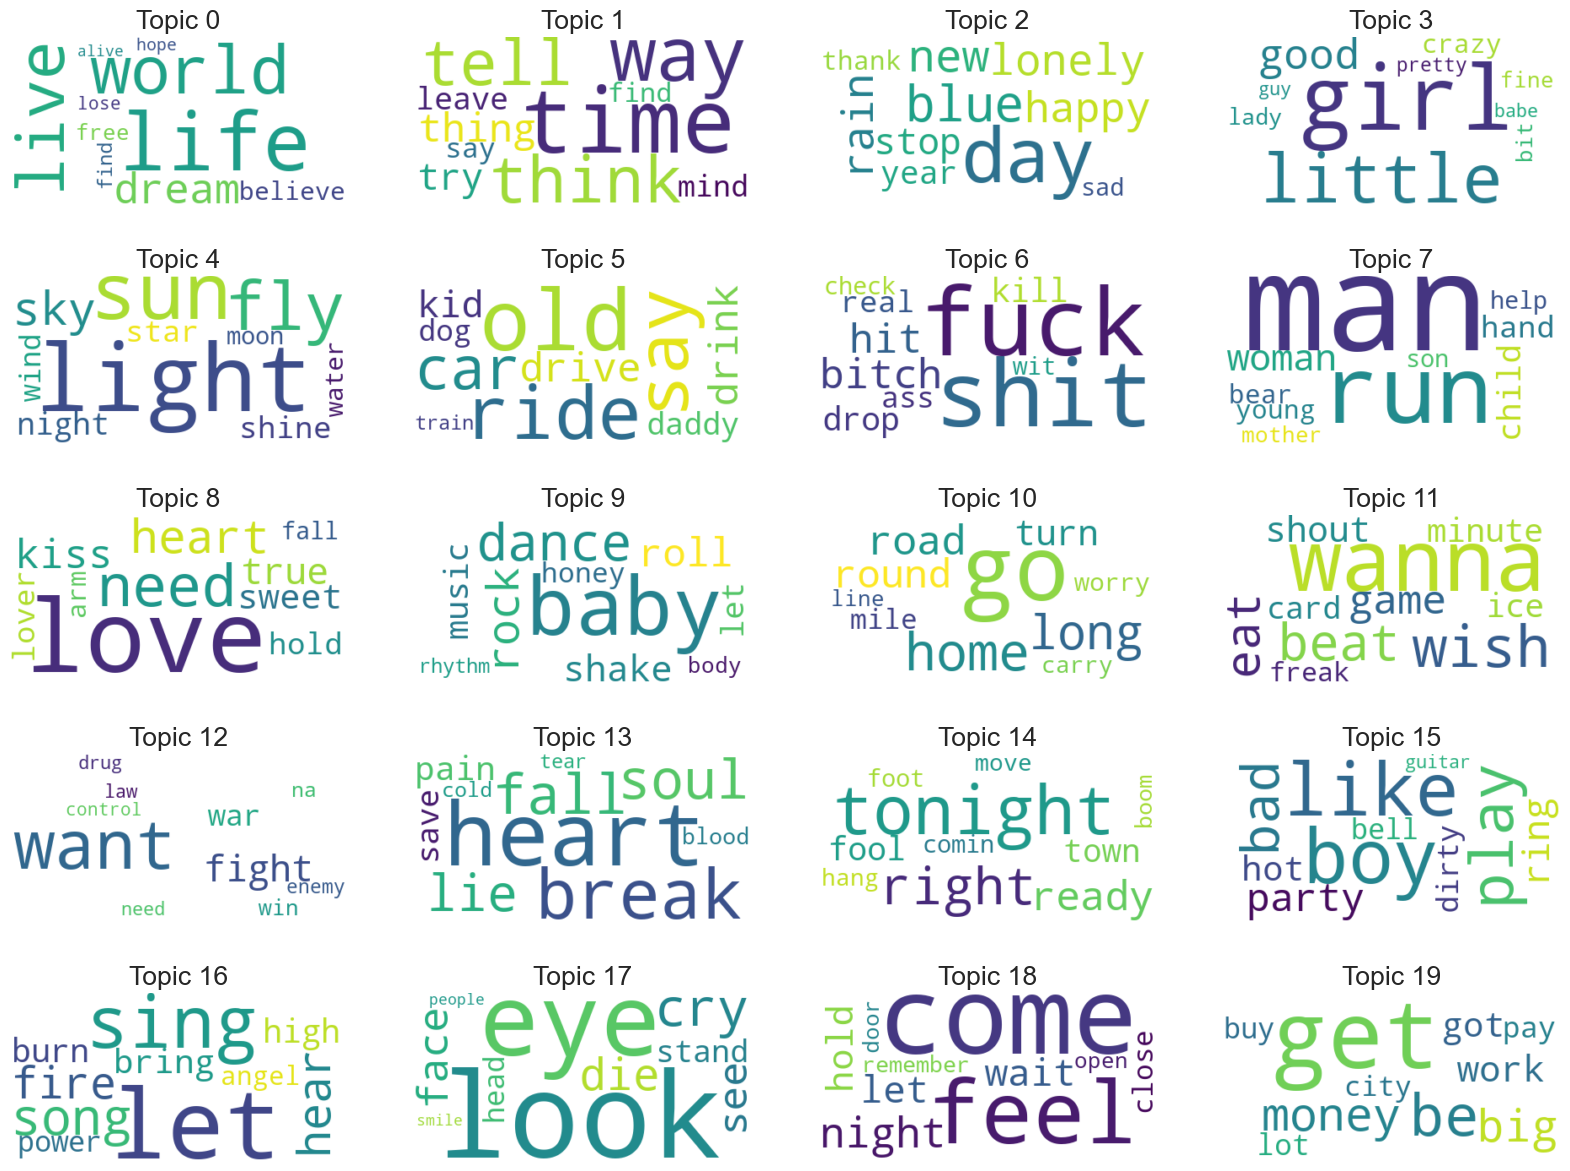

In [16]:
# Plot word clouds for each topic
word_cloud = WordCloud(background_color='white', max_words=10)
fig, axes = plt.subplots(5, 4, figsize=(20,15))

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(lda_model.show_topic(i))
    word_cloud.generate_from_frequencies(topic_words)
    plt.gca().imshow(word_cloud, interpolation='bilinear')
    plt.gca().set_title(f'Topic {i}')
    plt.gca().axis('off')
plt.show()

In [17]:
import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow, dct)
vis

/Users/cslab/brewPythonVENV/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=72990) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/Users/cslab/brewPythonVENV/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=72990) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/Users/cslab/brewPythonVENV/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=72990) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/Users/cslab/brewPythonVENV/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=72990) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/Users/cslab/brewPythonVENV/lib/python3.12/site-packages

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.088742  0.118350       1        1  16.335634
4      0.113329 -0.143834       2        1   8.917253
18     0.169653  0.062414       3        1   7.772167
17     0.108249 -0.134041       4        1   7.128185
0      0.215111  0.034277       5        1   6.582381
6     -0.113129 -0.121741       6        1   5.947640
13     0.171811 -0.086350       7        1   5.435406
8      0.166881  0.216887       8        1   4.959780
5     -0.156034 -0.089450       9        1   4.847696
19    -0.197627  0.023520      10        1   4.814252
16     0.119656 -0.088256      11        1   4.112155
10    -0.022093 -0.029834      12        1   3.493897
2      0.125572  0.019544      13        1   3.021010
12    -0.039939 -0.081227      14        1   3.004395
7     -0.031930 -0.101099      15        1   2.967048
3     -0.110379  0.259774      16        1   2.898866
9     -0.117366  0.190498      17        1   2.353754
15    -0.204521 -0.018900      18        1   2.130868
11    -0.155839 -0.080673      19        1   1.783843
14    -0.130147  0.050139      20        1   1.493772, topic_info=       Term          Freq         Total Category  logprob  loglift
73     love  96339.000000  96339.000000  Default  30.0000  30.0000
126      go  61150.000000  61150.000000  Default  29.0000  29.0000
205    want  47014.000000  47014.000000  Default  28.0000  28.0000
67      get  62565.000000  62565.000000  Default  27.0000  27.0000
55     baby  31227.000000  31227.000000  Default  26.0000  26.0000
...     ...           ...           ...      ...      ...      ...
1399    gal    250.982499    377.346979  Topic20  -5.4758   3.7961
480   tight    491.450639   2433.817285  Topic20  -4.8039   2.6040
741   teach    373.545186   1681.607046  Topic20  -5.0782   2.6994
67      get    923.123709  62565.884162  Topic20  -4.1734  -0.0123
465   sight    392.243486   2150.322576  Topic20  -5.0293   2.5024

[1349 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
2197      3  0.936475   Come
2197      6  0.002493   Come
2197     11  0.002493   Come
2197     16  0.000831   Come
2197     17  0.011633   Come
...     ...       ...    ...
294      12  0.003484  young
294      13  0.002710  young
294      14  0.001548  young
294      15  0.693136  young
294      16  0.042196  young

[5140 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 19, 18, 1, 7, 14, 9, 6, 20, 17, 11, 3, 13, 8, 4, 10, 16, 12, 15])

In [18]:
# Compute topic probabilities for each document
results = []
for i, doc in enumerate(bow):
    topic_probs = lda_model[doc]  # List of (topic_id, probability)
    for topic_id, prob in topic_probs:
        results.append({
            "song": songs_df.iloc[i]["song"],
            "topic": topic_id,
            "topic_probability": prob
        })

# Convert results to a DataFrame
topic_df = pd.DataFrame(results)

# Get top 10 contributors for each topic
top_contributors = (
    topic_df.sort_values(by=["topic", "topic_probability"], ascending=[True, False])
    .groupby("topic")
    .head(10)  # Get top 10 for each topic
    .reset_index(drop=True)
)

# Pivot table for a clear overview
summary_table = top_contributors.groupby("topic")["song"].apply(list).reset_index()
summary_table.columns = ["Topic", "Top Contributors"]

In [19]:
# Top Songs for Each Topic
summary_table.head()

,Topic,Top Contributors
0,0,"[This Is Not My Life, Beautiful People, Memory Of The Future, Reason I Live, Believe, Dream A Dream, Imagine, Questions Still Remain, I Believe, Found Found Found]"
1,1,"[Better Together, Hard Time, Talkin' Talkin', Explain It To My Heart, I Don't Think We Could Ever Be Friends, Everything Means Something, 5446, It's Never Too Late, Goodbye, Change Your Mind]"
2,2,"[Lonely Days, Paskong Kay Ganda, Ikaw Ang Aking Mahal, Ikaw Na Ang Bahala: Panalangin, Oh Happy Day, Only Happy When It Rains, Let A Smile Be Your Umbrella, Zip-A-Dee-Doo-Dah, Thank You Lord, Mach]"
3,3,"[Little By Little, Again, Be Good Johnny, Lucky Girl, Not Your Girl, Liza Jane, She Bop, A Little Bit Me, A Little Bit You, Hey, Lucky Lady, Negative Creep]"
4,4,"[Paint The Sky With Stars, I Go Swimming, This Land Is Your Land, Neon Lights, Fly Away, Sunset, Last Rose Of Summer, Despair, Julia, This Land Is Your Land]"


Similar Documents

In [20]:
# Compute and rank consine similarities
lda_index = similarities.MatrixSimilarity(lda_model[bow], num_features=len(dct))

In [21]:
# Returns most similar songs to a given song
def get_similar_songs(song_bow, top_n=5, first_m_words=300):
    similar_songs = lda_index[lda_model[song_bow]]
    top_n_docs = sorted(enumerate(similar_songs), key=lambda item: -item[1])[1:top_n+1]
  
    # Returns (song id, similarity score, first_m_words of song)
    return list(map(lambda entry: (entry[0], entry[1], clean_data[entry[0]][:first_m_words]), top_n_docs))

In [22]:
# Example
print(data[6864][:300],'\n')
get_similar_songs(bow[6864])

[Verse:]  
She's just a girl and she's on fire  
Hotter than a fantasy, lonely like a highway  
She's living in a world and it's on fire  
Filled with catastrophe, but she knows she can fly away  
  
Ohhhh oh oh oh oh  
She got both feet on the ground  
And she's burning it down  
Ohhhh oh oh oh oh  



[(35112,
  0.9660541,
  "Little stranger in a manger little stranger sweet and mild  Mother Mary daddy Joseph watch o'er you their holy child  Searching for you to adore you come Three Kings led by a star  Little stranger in a manger they'll find heaven where you are  Choir of angels are singing this night of your birth  Pr"),
 (37293,
  0.9636971,
  'Lord You are Good  And your mercy endureth forever  Lord You are good  And your mercy endureth forever  (Repeat 3xs)    People from every nation and tongue  From generation to generation  We worship you  Hallelujah, Hallelujah,  We worship you for who you are.  We worship you  Hallelujah, Hallelujah'),
 (39340,
  0.95442814,
  'Look upon the Lord  Stand in awe of His beauty  Look upon the Lord  Seated high, He is Holy    Let the glory of our God from Heaven come down  Let the house of the Lord be filled with the cloud    You are good and Your mercy will endure  You are good and forever we are Yours  Hallelujah, Hallelujah '),
 (37282,
  0

In [23]:
#Songs not in corpus
# Pass new song through pipeline
new_song = "Demons on my shoulder Monsters in my head Shadow in the water Will you be my friend The world revolves around me As I lay in my bed Dreaming of more, more"
new_tokens = list(map(custom_tokenizer, [nlp(new_song)]))[0]
new_bow = dct.doc2bow(new_tokens)

print(new_song,'\n')
get_similar_songs(new_bow)

Demons on my shoulder Monsters in my head Shadow in the water Will you be my friend The world revolves around me As I lay in my bed Dreaming of more, more 



/Users/cslab/brewPythonVENV/lib/python3.12/site-packages/spacy/language.py:1067: DeprecationWarning: [W096] The method `nlp.disable_pipes` is now deprecated - use `nlp.select_pipes` instead.
  warnings.warn(Warnings.W096, DeprecationWarning)


[(28777,
  0.9718935,
  "Standing here  The old man said to me  Long before these crowded streets  Here stood my dreaming tree  Below it he would sit  For hours at a time  Now progress takes away  What forever took to find  And now he's falling hard  He feels the falling dark  How he longs to be  Beneath his dreaming tree  "),
 (42930,
  0.9674121,
  "The rain auditions at my window  Its symphony echoes in my womb  My gaze scans the walls of this apartment  To rectify the confines of my tomb    I'm the cyclops in the tenement  I'm the soul without the cause  Crying midst my rubber plants, ignoring beckoning doors  Clippings from ancient newspaper"),
 (56828,
  0.96615386,
  "I'm wandering the town all light off  I don't know where I'm leaving for  The muddy rain start to fall on me  And I'm walking down to subway    I can't see all around me  Get me out of here  Talk to me if someone is in this darkness    I'm out of my head  Out of my mind  Tell me where I'm what's goi"),
 (20115,
  0

In [24]:
from spotipy import Spotify
from spotipy.oauth2 import SpotifyClientCredentials


In [25]:
CLIENT_ID = "4de7e3df967549698fdaefad9db413bd"
CLIENT_SECRET = "976e1232fabf4d0fa3f49b02731fb3da"

In [26]:
sp = Spotify(auth_manager=SpotifyClientCredentials(client_id=CLIENT_ID, client_secret=CLIENT_SECRET))

In [27]:
playlist_id = "1yDawcV25BRwf149OFGgia" #https://open.spotify.com/playlist/1yDawcV25BRwf149OFGgia

In [28]:
def analyze_playlist(creator, playlist_id):
    playlist_features_list = ["artist","album","track_name",  "track_id","danceability","energy","key","loudness","mode", "speechiness","instrumentalness","liveness","valence","tempo", "duration_ms","time_signature"]
    
    playlist_df = pd.DataFrame(columns = playlist_features_list)
        
    playlist = sp.user_playlist_tracks(creator, playlist_id)["items"]
    for track in playlist:
        playlist_features = {}

        playlist_features["artist"] = track["track"]["album"]["artists"][0]["name"]
        playlist_features["album"] = track["track"]["album"]["name"]
        playlist_features["track_name"] = track["track"]["name"]
        playlist_features["track_id"] = track["track"]["id"]
        
        
        audio_features = sp.audio_features(playlist_features["track_id"])[0]
        for feature in playlist_features_list[4:]:
            playlist_features[feature] = audio_features[feature]
        
        track_df = pd.DataFrame(playlist_features, index = [0])
        playlist_df = pd.concat([playlist_df, track_df], ignore_index = True)
        
    return playlist_df

In [ ]:
table = analyze_playlist("ugoanyaegbunam", playlist_id)
table = table.round(2)
table.head(45)

In [ ]:
def get_dominant_topic(lda_model, lyrics):
    # Get the topic distribution for the song
    topic_distribution = lda_model.get_document_topics(lda_model.id2word.doc2bow(lyrics.split()))  # Returns a list of tuples (topic_id, distribution)
    
    # If the topic_distribution is empty (e.g., no relevant topics), return None or a default topic
    if not topic_distribution:
        return None

    # Sort the topic distribution in descending order to get the topic with the highest distribution
    sorted_topics = sorted(topic_distribution, key=lambda x: x[1], reverse=True)

    # Return the topic number with the highest distribution
    return sorted_topics[0][0]  # Topic number is the first element of the tuple (topic_id)


In [ ]:
def get_track_id(song_name, artist_name):
    # Create a search query using song name and artist
    query = f"track:{song_name} artist:{artist_name}"
    
    # Search for the track
    results = sp.search(q=query, type='track', limit=1)
    
    # Check if results are returned
    if results['tracks']['items']:
        # Get the first result (most relevant)
        track = results['tracks']['items'][0]
        track_id = track['id']
        return track_id
    else:
        # No results found
        return None

In [ ]:
import time
from spotipy import SpotifyException
def get_song_features(song_name, artist_name, retries=5, backoff_factor=1.5):
    track_id = get_track_id(song_name, artist_name)
    
    if not track_id:
        features = {
        'danceability': np.nan, 
        'energy': np.nan, 
        'key': np.nan, 
        'loudness': np.nan, 
        'mode': np.nan, 
        'speechiness': np.nan, 
        'instrumentalness': np.nan, 
        'liveness': np.nan, 
        'valence': np.nan, 
        'tempo': np.nan
        }
        return features
    
    for attempt in range(retries):
        try:
            features = sp.audio_features([track_id])[0]
            return features
        except SpotifyException as e:
            if e.http_status == 429:  # Rate limit error
                wait_time = backoff_factor ** attempt + random.uniform(0, 1)  # Exponential backoff with random jitter
                print(f"Rate limit hit, retrying in {wait_time:.2f} seconds...")
                time.sleep(wait_time)
            else:
                raise  # Re-raise if it's not a rate limit error
    
    raise Exception(f"Max retries reached for fetching audio features for {song_name} by {artist_name}")

In [ ]:
def mode(series):
    return series.mode().iloc[0] if not series.mode().empty else None

In [ ]:
def get_avg_topic_features(songs_df):   
    danceability_vals = []
    energy_vals = []
    key_vals = []
    loudness_vals = []
    mode_vals = []
    speechiness_vals = []
    instrumentalness_vals = []
    liveness_vals = []
    valence_vals = []
    tempo_vals = []
    dominant_topics = []

    for index, row in songs_df.iterrows():
        song_name = row['song']  
        artist = row['artist']  
        lyrics = row['text']      

        features = get_song_features(song_name, artist)
        dominant_topic = get_dominant_topic(lda_model, lyrics)

        danceability_vals.append(features['danceability'])
        energy_vals.append(features['energy'])
        key_vals.append(features['key'])
        loudness_vals.append(features['loudness'])
        mode_vals.append(features['mode'])
        speechiness_vals.append(features['speechiness'])
        instrumentalness_vals.append(features['instrumentalness'])
        liveness_vals.append(features['liveness'])
        valence_vals.append(features['valence'])
        tempo_vals.append(features['tempo'])
        dominant_topics.append(dominant_topic)
    
    songs_df['danceability'] = danceability_vals
    songs_df['energy'] = energy_vals
    songs_df['key'] = key_vals
    songs_df['loudness'] = loudness_vals
    songs_df['mode'] = mode_vals
    songs_df['speechiness'] = speechiness_vals
    songs_df['instrumentalness'] = instrumentalness_vals
    songs_df['liveness'] = liveness_vals
    songs_df['valence'] = valence_vals
    songs_df['tempo'] = tempo_vals
    songs_df['dominant_topic'] = dominant_topics

    # Group by 'topic' and calculate statistics
    grouped_df = songs_df.groupby('dominant_topic').agg({
        'danceability': 'mean',  
        'energy': 'mean',        
        'key': 'mean',
        'loudness': 'mean',
        'mode': 'mean',
        'speechiness': 'mean',
        'instrumentalness': 'mean',
        'liveness' : 'mean',
        'valence' : 'mean',
        'tempo' : 'mean'
    }).reset_index()

    # Rename columns for clarity
    grouped_df.rename(columns={
    'dominant_topic': 'topic',
    'danceability': 'avg_danceability',
    'energy': 'avg_energy',
    'key': 'avg_key',
    'loudness': 'avg_loudness',
    'mode': 'avg_mode',
    'speechiness': 'avg_speechiness',
    'instrumentalness': 'avg_instrumentalness',
    'liveness': 'avg_liveliness',
    'valence': 'avg_valence',
    'tempo': 'avg_tempo'
    }, inplace=True)

    return grouped_df



In [ ]:
contributors = summary_table['Top Contributors'].explode().unique()  
filtered_songs_df = songs_df[songs_df['song'].isin(contributors)]
topic_avgs = get_avg_topic_features(filtered_songs_df)

C:\Users\Ugo Anyaegbunam\AppData\Local\Temp\ipykernel_16828\4124746230.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  songs_df['danceability'] = danceability_vals
C:\Users\Ugo Anyaegbunam\AppData\Local\Temp\ipykernel_16828\4124746230.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  songs_df['energy'] = energy_vals
C:\Users\Ugo Anyaegbunam\AppData\Local\Temp\ipykernel_16828\4124746230.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

In [ ]:
topic_avgs = topic_avgs.round(2)
topic_avgs.head(20)

,topic,avg_danceability,avg_energy,avg_key,avg_loudness,avg_mode,avg_speechiness,avg_instrumentalness,avg_liveliness,avg_valence,avg_tempo
0,0,0.50,0.57,4.56,-9.14,0.79,0.04,0.05,0.21,0.40,121.56
1,1,0.55,0.69,5.12,-8.08,0.73,0.06,0.07,0.23,0.59,122.89
2,2,0.52,0.57,4.17,-9.18,0.75,0.06,0.10,0.25,0.58,128.32
3,3,0.58,0.78,5.78,-7.78,0.56,0.05,0.10,0.21,0.75,112.32
4,4,0.54,0.65,6.17,-9.43,0.83,0.05,0.07,0.22,0.54,124.15
5,5,0.56,0.55,5.15,-10.17,0.77,0.11,0.13,0.25,0.69,137.66
6,6,0.57,0.76,4.09,-7.87,0.64,0.08,0.22,0.25,0.46,111.56
7,7,0.57,0.67,6.56,-9.55,0.78,0.05,0.01,0.22,0.68,120.38
8,8,0.57,0.58,5.07,-10.26,0.80,0.06,0.10,0.24,0.66,124.58
9,9,0.52,0.64,7.18,-10.20,0.82,0.04,0.02,0.14,0.53,125.23


In [ ]:
def process_new_song(song, lyrics, lda_model, dictionary):
    # Preprocess the text (tokenize and convert to bag-of-words)
    bow = dictionary.doc2bow(lyrics.lower().split())
    
    # Get topic probabilities
    topic_probs = lda_model.get_document_topics(bow)
    
    # Find the dominant topic
    dominant_topic, topic_prob = max(topic_probs, key=lambda x: x[1])
    
    # Return result as a dictionary
    return {"name": song, "dominant_topic": dominant_topic, "topic_probability": topic_prob}

In [ ]:
new_songs_to_lyrics = pd.read_csv('test_songs_lyrics - Sheet1.csv')

In [ ]:
song_to_gpt_topic = { "No One Noticed": "Topic 1", "Don't Stop The Music": "Topic 9", "Palms": "Topic 18", "Rude": "Topic 10", "Poison Ivy": "Topic 6", "Hellraiser": "Topic 6", "Cruisin' for a Bruisin": "Topic 9", "In the End": "Topic 0", "Unwritten": "Topic 0", "Sprinter": "Topic 7", "Crooked Smile": "Topic 7", "Get You": "Topic 8", "Ode To The Mets": "Topic 2", "Workin Out": "Topic 0", "E. Coli": "Topic 6", "Snooze": "Topic 8", "Survive (Ban Rap)": "Topic 6", "Broken Vessels (Amazing Grace)": "Topic 0", "Last Time I Saw You": "Topic 1", "Motivation": "Topic 1", "Centuries": "Topic 5", "Courtesy Call": "Topic 6", "Best Mistake": "Topic 8", "Home": "Topic 10", "Send My Love (To Your New Lover)": "Topic 8", "Legends Never Die": "Topic 5", "How To Love": "Topic 8", "Boo'd Up": "Topic 8", "Adore You": "Topic 8", "Hold On": "Topic 0", "Mary On A Cross": "Topic 7", "Them Changes": "Topic 8", "The Color Violet": "Topic 8", "Rockstar": "Topic 6", "Fishin' in the Dark": "Topic 5", "3 Nights": "Topic 10", "End of Beginning": "Topic 0", "Hotel California": "Topic 7", "Southern Nights": "Topic 10", "Birds of a Feather": "Topic 4", "Play That Funky Music": "Topic 9", "Smooth Operator": "Topic 9", "Higher": "Topic 0", "Lost": "Topic 1", "Somewhere Over The Rainbow/What A Wonderful World": "Topic 4" }
our_topic_assignments = dict(zip(song_to_gpt_topic.keys(),[2,9,10,8,3,9,5,13,0,19,3,8,17,13,0,8,13,17,13,15,1,16,8,10,8,12,8,9,3,18,10,13,13,19,4,14,18,8,4,17,9,7,0,3,0 ]))
model_to_topic = {}
for song in song_to_gpt_topic.keys():
    df = new_songs_to_lyrics
    lyrics = df.loc[df['song'] == song, 'lyrics'].iloc[0]
    results = process_new_song(song, lyrics, lda_model, dct)
    model_to_topic[song] = results

songs_ordered = list(our_topic_assignments.keys())  # Assuming this is the correct order

# Create a dataframe keeping the song order intact
df = pd.DataFrame({
    'song_name': songs_ordered,
    'our_placement': ['Topic ' + str(our_topic_assignments[song]) for song in songs_ordered],
    'chatgpt_placement': [str(song_to_gpt_topic.get(song, '')) for song in songs_ordered],
    'model_dominant_topic': ['Topic ' + str(model_to_topic.get(song, {}).get('dominant_topic', '')) for song in songs_ordered],
    'topic_probability': [model_to_topic.get(song, {}).get('topic_probability', '') for song in songs_ordered]
})
print(our_topic_assignments)
print(song_to_gpt_topic)
print(model_to_topic)

{'No One Noticed': 2, "Don't Stop The Music": 9, 'Palms': 10, 'Rude': 8, 'Poison Ivy': 3, 'Hellraiser': 9, "Cruisin' for a Bruisin": 5, 'In the End': 13, 'Unwritten': 0, 'Sprinter': 19, 'Crooked Smile': 3, 'Get You': 8, 'Ode To The Mets': 17, 'Workin Out': 13, 'E. Coli': 0, 'Snooze': 8, 'Survive (Ban Rap)': 13, 'Broken Vessels (Amazing Grace)': 17, 'Last Time I Saw You': 13, 'Motivation': 15, 'Centuries': 1, 'Courtesy Call': 16, 'Best Mistake': 8, 'Home': 10, 'Send My Love (To Your New Lover)': 8, 'Legends Never Die': 12, 'How To Love': 8, "Boo'd Up": 9, 'Adore You': 3, 'Hold On': 18, 'Mary On A Cross': 10, 'Them Changes': 13, 'The Color Violet': 13, 'Rockstar': 19, "Fishin' in the Dark": 4, '3 Nights': 14, 'End of Beginning': 18, 'Hotel California': 8, 'Southern Nights': 4, 'Birds of a Feather': 17, 'Play That Funky Music': 9, 'Smooth Operator': 7, 'Higher': 0, 'Lost': 3, 'Somewhere Over The Rainbow/What A Wonderful World': 0}
{'No One Noticed': 'Topic 1', "Don't Stop The Music": 'Top

In [ ]:
df = df.round(2)
df.head(45)

,song_name,our_placement,chatgpt_placement,model_dominant_topic,topic_probability
0,No One Noticed,Topic 2,Topic 1,Topic 1,0.20
1,Don't Stop The Music,Topic 9,Topic 9,Topic 1,0.15
2,Palms,Topic 10,Topic 18,Topic 0,0.26
3,Rude,Topic 8,Topic 10,Topic 19,0.17
4,Poison Ivy,Topic 3,Topic 6,Topic 13,0.20
5,Hellraiser,Topic 9,Topic 6,Topic 0,0.20
6,Cruisin' for a Bruisin,Topic 5,Topic 9,Topic 5,0.22
7,In the End,Topic 13,Topic 0,Topic 1,0.37
8,Unwritten,Topic 0,Topic 0,Topic 18,0.21
9,Sprinter,Topic 19,Topic 7,Topic 6,0.16


In [ ]:
import dataframe_image as dfi

dfi.export(topic_avgs, "topicavgs.png")

In [ ]:
from scipy.spatial.distance import jensenshannon

def calculate_topic_consistency(lda_model, corpus, top_n=20):
    """
    Calculate topic consistency using Jensen-Shannon distance
    
    Parameters:
    - lda_model: trained Gensim LDA model
    - corpus: document corpus used for training
    - top_n: number of top words to consider
    """
    # Get topic distributions for all documents
    doc_topics = [lda_model.get_document_topics(doc) for doc in corpus]
    
    # Convert to dense vectors
    doc_topic_dist = [[prob for _, prob in sorted(doc)] 
                     for doc in doc_topics]
    
    # Calculate pairwise distances
    distances = []
    for i in range(len(doc_topic_dist)):
        for j in range(i+1, len(doc_topic_dist)):
            dist = jensenshannon(doc_topic_dist[i], doc_topic_dist[j])
            distances.append(dist)
    
    # Average distance (lower = more consistent)
    consistency = 1 - np.mean(distances)
    
    return consistency

# Usage
consistency_score = calculate_topic_consistency(lda_model, corpus=bow)

In [ ]:
def calculate_topic_diversity(lda_model=bow, top_n=20):
    """
    Calculate topic diversity - ratio of unique words across all topics
    
    Parameters:
    - lda_model: trained Gensim LDA model
    - top_n: number of top words per topic to consider
    
    Returns:
    - diversity score between 0 and 1 (higher = more diverse)
    """
    # Get top words for each topic
    topics = [dict(lda_model.show_topic(topic_id, topn=top_n)) 
             for topic_id in range(lda_model.num_topics)]
    
    # Get unique words across all topics
    unique_words = set(word for topic in topics 
                      for word, _ in topic.items())
    
    # Calculate diversity: unique words / (top_n * num_topics)
    diversity = len(unique_words) / (top_n * lda_model.num_topics)
    
    return diversity

# Usage
diversity_score = calculate_topic_diversity(lda_model, top_n=20)